In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [2]:
%%shell
wget -P ./data https://download.pytorch.org/tutorial/hymenoptera_data.zip

unzip ./data/hymenoptera_data.zip -d ./data

--2022-03-21 10:53:15--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 52.84.18.100, 52.84.18.119, 52.84.18.116, ...
Connecting to download.pytorch.org (download.pytorch.org)|52.84.18.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘./data/hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   121MB/s    in 0.4s    

2022-03-21 10:53:15 (121 MB/s) - ‘./data/hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  ./data/hymenoptera_data.zip
   creating: ./data/hymenoptera_data/
   creating: ./data/hymenoptera_data/train/
   creating: ./data/hymenoptera_data/train/ants/
  inflating: ./data/hymenoptera_data/train/ants/0013035.jpg  
  inflating: ./data/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: ./data/hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: ./data/hymenoptera_data/tr

In [3]:
from torch._C import device
from matplotlib import image
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = "data/hymenoptera_data"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ["train", "val"]}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4) for x in ["train", "val"]}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


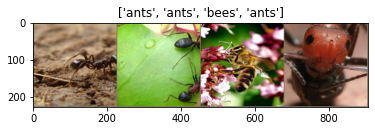

In [4]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders["train"]))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print("{} Loss: {:.4f} Acc: {:.4f}".format(
                phase, epoch_loss, epoch_acc))
            
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
        print()

    time_elapsed = time.time() - since
    print("Training complete in {:.0f}m {:.0f}s".format(
        time_elapsed // 60, time_elapsed % 60))
    print("Best val Acc: {:4f}".format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders["val"]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis("off")
                ax.set_title("predicted: {}".format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6874 Acc: 0.6516
val Loss: 0.3646 Acc: 0.8366

Epoch 1/24
----------
train Loss: 0.5285 Acc: 0.7541
val Loss: 0.2262 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.5455 Acc: 0.7992
val Loss: 0.2181 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.5353 Acc: 0.7787
val Loss: 0.1980 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.4789 Acc: 0.7787
val Loss: 0.2203 Acc: 0.8954

Epoch 5/24
----------
train Loss: 0.3794 Acc: 0.8238
val Loss: 0.2171 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.4716 Acc: 0.8115
val Loss: 0.2386 Acc: 0.9085

Epoch 7/24
----------
train Loss: 0.3420 Acc: 0.8607
val Loss: 0.1808 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3083 Acc: 0.8852
val Loss: 0.1722 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.3124 Acc: 0.8525
val Loss: 0.1836 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.3471 Acc: 0.8607
val Loss: 0.2351 Acc: 0.8889

Epoch 11/24
----------
train Loss: 0.2461 Acc: 0.8975
val Loss: 0.2432 Acc: 0.9020

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


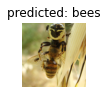

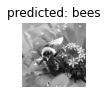

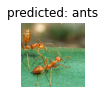

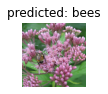

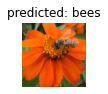

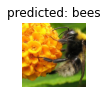

In [11]:
visualize_model(model_ft)

In [12]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [13]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.7009 Acc: 0.6189
val Loss: 0.2236 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.4212 Acc: 0.8156
val Loss: 0.3628 Acc: 0.8431

Epoch 2/24
----------
train Loss: 0.6340 Acc: 0.7172
val Loss: 0.2249 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.4680 Acc: 0.7992
val Loss: 0.2356 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.5573 Acc: 0.7705
val Loss: 0.2550 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.3673 Acc: 0.8566
val Loss: 0.2741 Acc: 0.9085

Epoch 6/24
----------
train Loss: 0.4735 Acc: 0.8033
val Loss: 0.1678 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.3522 Acc: 0.8279
val Loss: 0.1810 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3040 Acc: 0.8770
val Loss: 0.1644 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3962 Acc: 0.8402
val Loss: 0.1712 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3702 Acc: 0.8279
val Loss: 0.1761 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.3575 Acc: 0.8525
val Loss: 0.1656 Acc: 0.9477

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


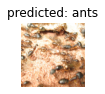

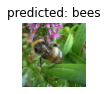

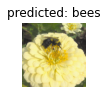

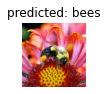

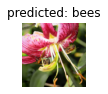

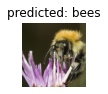

In [14]:
visualize_model(model_conv)

plt.ioff()
plt.show()